# Using Ridge regression for supervised-unsupervised topic mappings
## 1. Rationale

* **Problem:**
  Supervised models produce direct predictions for your target labels (multi-label classification). Unsupervised topic models, however, produce *topics*, which are not the same as your labels. To compare fairly, you need a *mapping* between topics and labels.

* **Why Ridge regression?**

  * Each document has a topic mixture vector (length K).
  * Each document also has binary labels (length L).
  * Ridge regression lets you learn a weight matrix $W \in \mathbb{R}^{K \times L}$ such that:

    $$
    Y \approx T \cdot W
    $$

    where $Y$ is the label matrix and $T$ is the topic mixture matrix.
  * Ridge is stable even with correlated topics and prevents overfitting by penalizing large coefficients.
  * Adding the **non-negativity constraint** makes the interpretation natural: topics can only *add evidence* for labels, not subtract.

* **Benefit over manual matching:**
  Manual mapping (human assigning topics to labels) is feasible for small K/L, but it's subjective, labor-intensive, and one-to-one. Ridge provides a **data-driven many-to-many** mapping and can reveal when multiple topics together explain one label.

---

## 2. Methodology (high level)

1. **Prepare data**

   * Get document-level topic distributions from your unsupervised model (BERTopic, LDA, etc.).
   * Ensure the same train/val/test splits are used as in the supervised experiment.
   * Use validation documents for learning the mapping.

2. **Fit mapping on validation**

   * Train a ridge regression (per label) from topics → labels.
   * Coefficients give you how strongly each topic contributes to each label.
   * Clip negatives to zero for interpretability.

3. **Calibrate thresholds**

   * The ridge outputs are continuous scores.
   * On validation, tune thresholds per label to maximize F1 (or balance precision/recall).
   * Store these thresholds for test evaluation.

4. **Predict on test**

   * Multiply test topic mixtures by $W$.
   * Apply thresholds to get predicted labels.
   * Compare against true labels.

5. **Evaluate**

   * Compute standard multilabel metrics: micro/macro F1, precision, recall, AUPRC.
   * Compare directly with your supervised classifier results.
   * (Optional) interpret mapping: for each label, see which topics contribute most.

---

## 3. Why this makes sense for your comparison

* **Fairness:** You evaluate both pipelines on the same test set, producing predictions in the same label space.
* **Minimal assumptions:** You don't enforce one-to-one topic↔label alignment (like Hungarian does).
* **Interpretability:** You can still inspect which topics map to which labels (from regression coefficients).
* **Simplicity:** It's lightweight (just a regression layer) and avoids heavy manual annotation.

In [11]:
import polars as pl
from loguru import logger
from pathlib import Path
from src.bertopic_pipeline import BERTopicPipeline
from tqdm.notebook import tqdm
import numpy as np
from bertopic import BERTopic
from src.evaluation import compute_all_metrics
from src.utils import get_mapping

In [2]:
from pathlib import Path
import polars as pl
import numpy as np

DATA_DIR = Path('data/blogs_articles')
MODEL_DIR = Path('models')
embedding_models = ['text-embedding-3-large', 'all-mpnet-base-v2', 'all-MiniLM-L12-v2']

def add_preds(df, topic_model):
    preds = []
    for r in tqdm(df.iter_rows(named=True), total =df.shape[0], desc="docs", position=1, leave=False):
        topics, probs = topic_model.transform(documents=r['chunks'], embeddings=np.array(r['chunks_embeddings']))
        preds.append({'id': r['id'], 'pred_topics': topics, 'pred_probs': probs})
    return df.join(pl.DataFrame(preds), on='id', how='left')

models = {}
train_set = set(pl.read_parquet(DATA_DIR / "train_topics.parquet")['id'].to_list())
val_set   = set(pl.read_parquet(DATA_DIR / "val_topics.parquet")['id'].to_list())
test_set  = set(pl.read_parquet(DATA_DIR / "test_topics.parquet")['id'].to_list())

for name in tqdm(embedding_models, total=len(embedding_models), desc='models', position=0):
    pipeline = BERTopicPipeline.load(MODEL_DIR / f'sv_topic_model_{name}')

    all_temp = pl.read_parquet(DATA_DIR / f"sv_embeddings_{name}.parquet")
    train_df = add_preds(all_temp.filter(pl.col("id").is_in(train_set)), pipeline.topic_model, )
    val_df   = add_preds(all_temp.filter(pl.col("id").is_in(val_set)), pipeline.topic_model)
    test_df  = add_preds(all_temp.filter(pl.col("id").is_in(test_set)), pipeline.topic_model)

    models[name] = {
        'pipeline': pipeline, 
        'train_df': train_df, 
        'val_df': val_df, 
        'test_df': test_df}

models:   0%|          | 0/3 [00:00<?, ?it/s]

docs:   0%|          | 0/2440 [00:00<?, ?it/s]

docs:   0%|          | 0/523 [00:00<?, ?it/s]

docs:   0%|          | 0/525 [00:00<?, ?it/s]

docs:   0%|          | 0/2440 [00:00<?, ?it/s]

docs:   0%|          | 0/523 [00:00<?, ?it/s]

docs:   0%|          | 0/525 [00:00<?, ?it/s]

docs:   0%|          | 0/2440 [00:00<?, ?it/s]

docs:   0%|          | 0/523 [00:00<?, ?it/s]

docs:   0%|          | 0/525 [00:00<?, ?it/s]

In [ ]:
models_ext = models
for name in tqdm(embedding_models, total = len(embedding_models), desc = 'model', position=0):
    temp_topic_mapper = TopicMapper(
        train_pred_topics = models[name]['train_df']['pred_topics'].to_list(), 
        train_gt_topics = models[name]['train_df']['topic_label'].to_list(),
        val_pred_topics = models[name]['val_df']['pred_topics'].to_list(), 
        val_gt_topics = models[name]['val_df']['topic_label'].to_list())
    temp_topic_mapper.fit_calibrate(alpha = 1.0)
    for part in tqdm(['train', 'val', 'test'], total = 3, desc = 'datasets', position = 1, leave = False):
        temp_mappings = temp_topic_mapper.map_predict(models[name][f'{part}_df']['pred_topics'].to_list())
        train_df = models[name][f'{part}_df'].with_columns(pl.Series("pred_mapped", temp_mappings))
        all_metrics = compute_all_metrics(
            models[name][f'{part}_df']['topic_label'].to_list(),
            temp_mappings, 
            get_mapping(id_to_label=True))
        per_label_table = all_metrics.pop('per_label_table')
        models_ext[name][f"{part}_df"] = train_df
        models_ext[name][f"{part}_all_metrics"] = all_metrics
        models_ext[name][f"{part}_per_label_table"] = pl.DataFrame(per_label_table)

model:   0%|          | 0/3 [00:00<?, ?it/s]

datasets:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:209: RuntimeWarning:

invalid value encountered in divide

c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:250: RuntimeWarning:

invalid value encountered in divide



datasets:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:209: RuntimeWarning:

invalid value encountered in divide

c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:250: RuntimeWarning:

invalid value encountered in divide



datasets:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:209: RuntimeWarning:

invalid value encountered in divide

c:\Users\povhi\OneDrive\01_Uni\03_TU Wien\MSc Data Science\09_Interdisciplinary_Project\ECB_Topic_Chronicles\src\evaluation.py:250: RuntimeWarning:

invalid value encountered in divide



In [51]:
for name in embedding_models: 
    for part in ['train', 'val', 'test']:
        df:pl.DataFrame = models[name][f'{part}_df']
        df = df.with_columns(
            pl.col("pred_probs").map_elements(
                lambda x: x.tolist() if hasattr(x, "tolist") else x,
                return_dtype=pl.List(pl.List(pl.Float64))))
        df.write_parquet(MODEL_DIR / f'topic_model_{name}' / f"{part}_df_pred.parquet" )

In [29]:
from src.evaluation import compute_all_metrics, plot_topic_metric_per_model, plot_metrics_per_model

In [30]:
for name in embedding_models: 
    for part in ['train', 'val', 'test']:
        models_ext[name][f"{part}_per_label_table"].write_csv(
            MODEL_DIR / f'topic_model_{name}' / f'topic_model_metrics_{part}.csv')

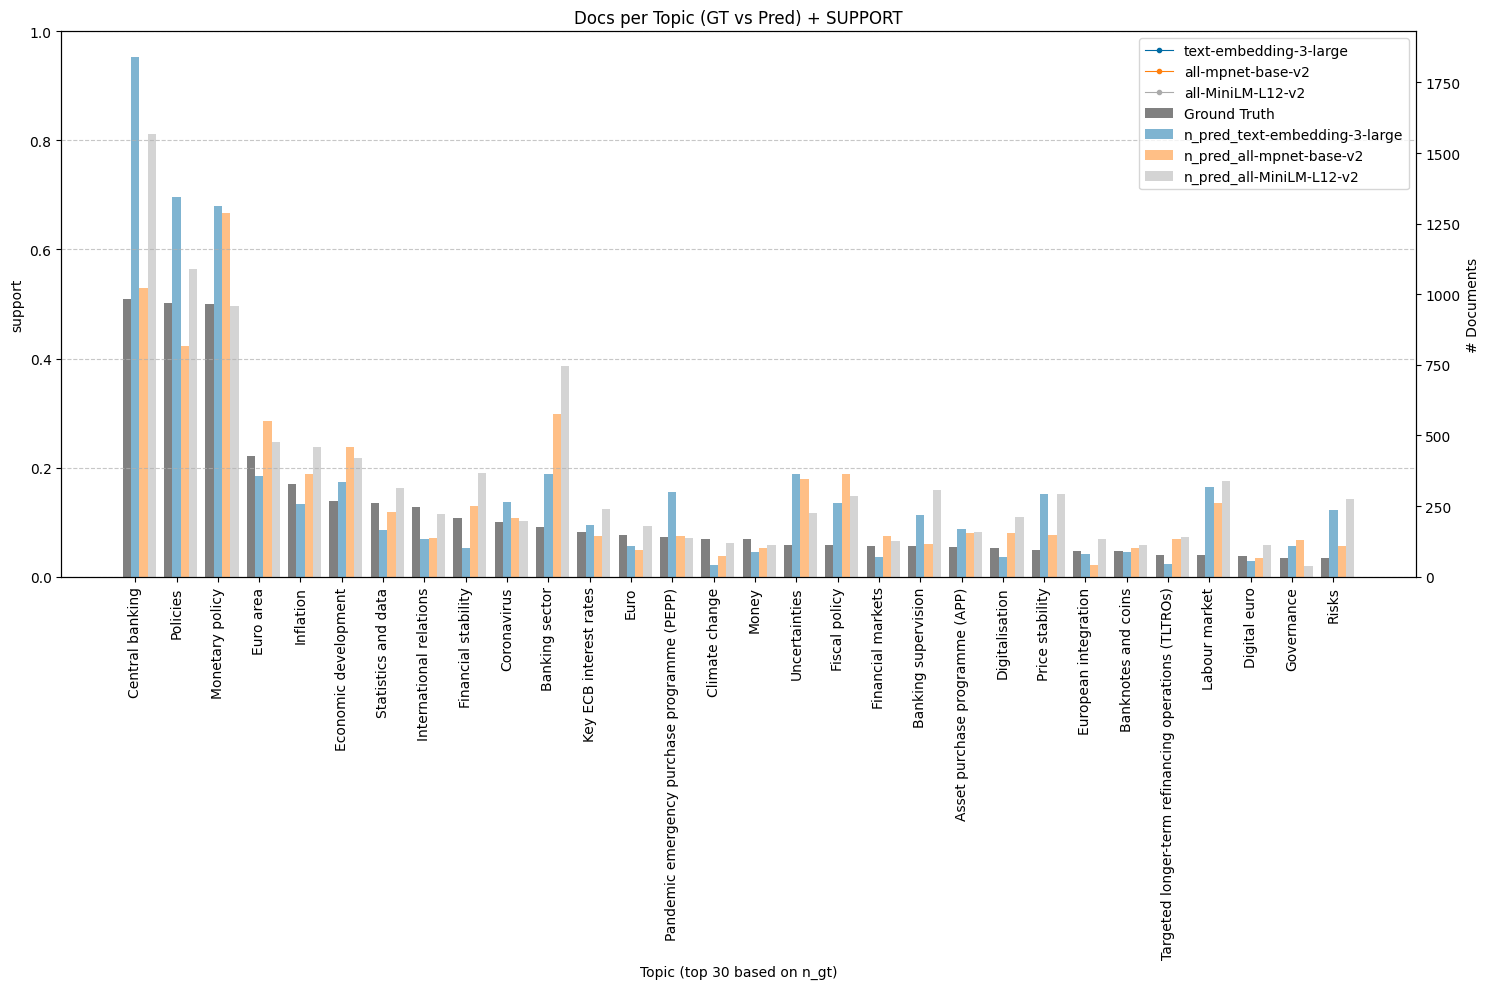

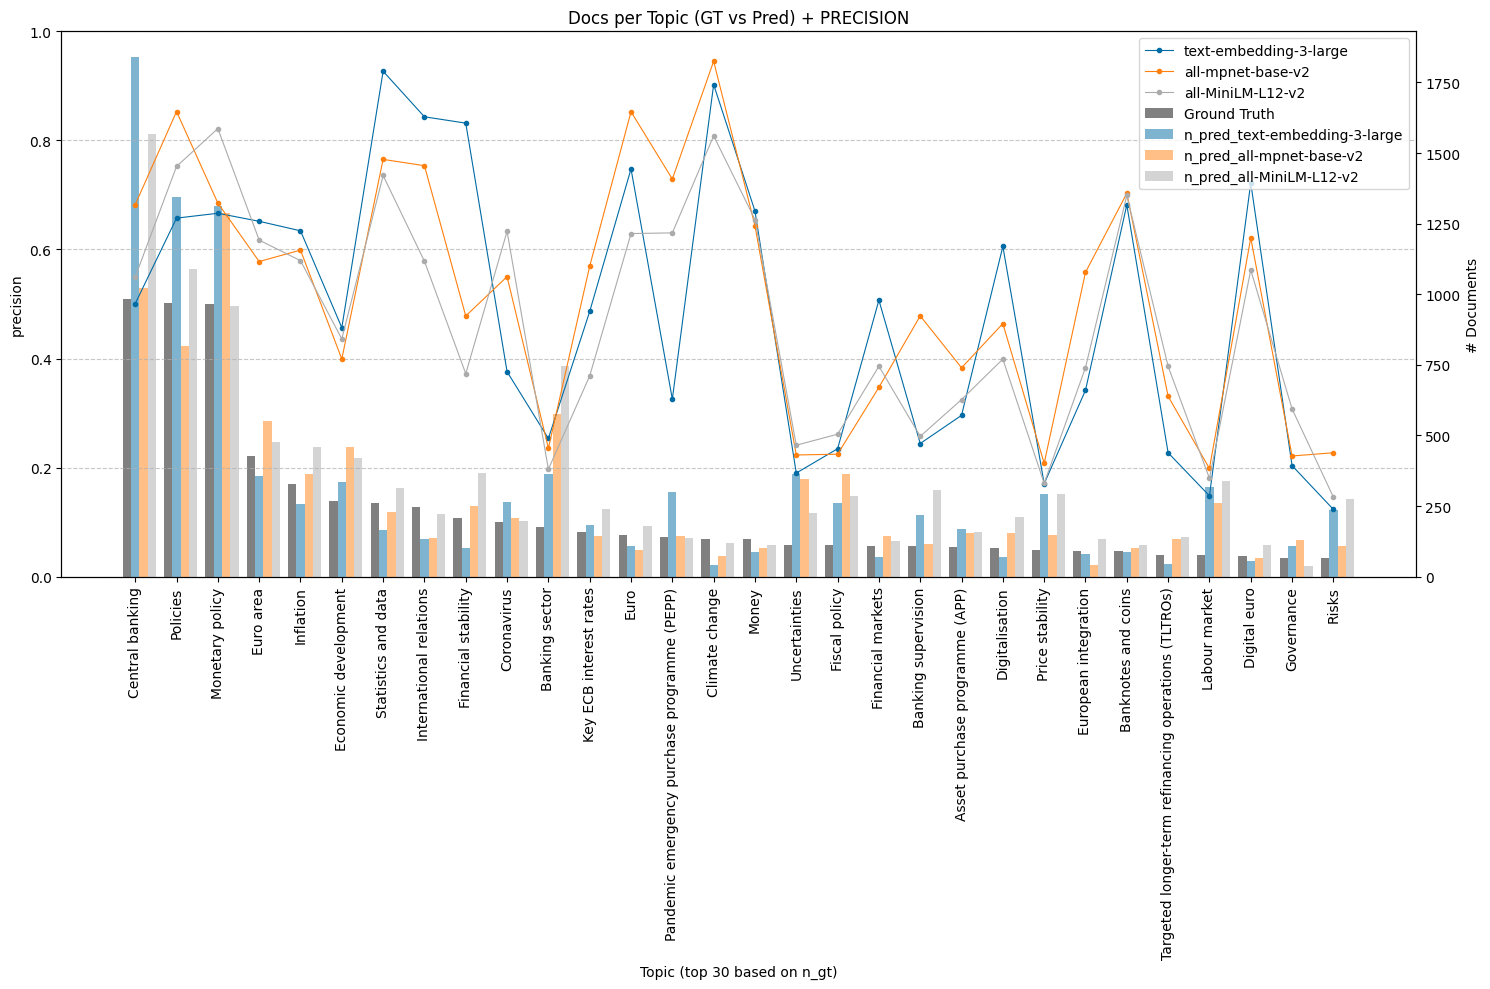

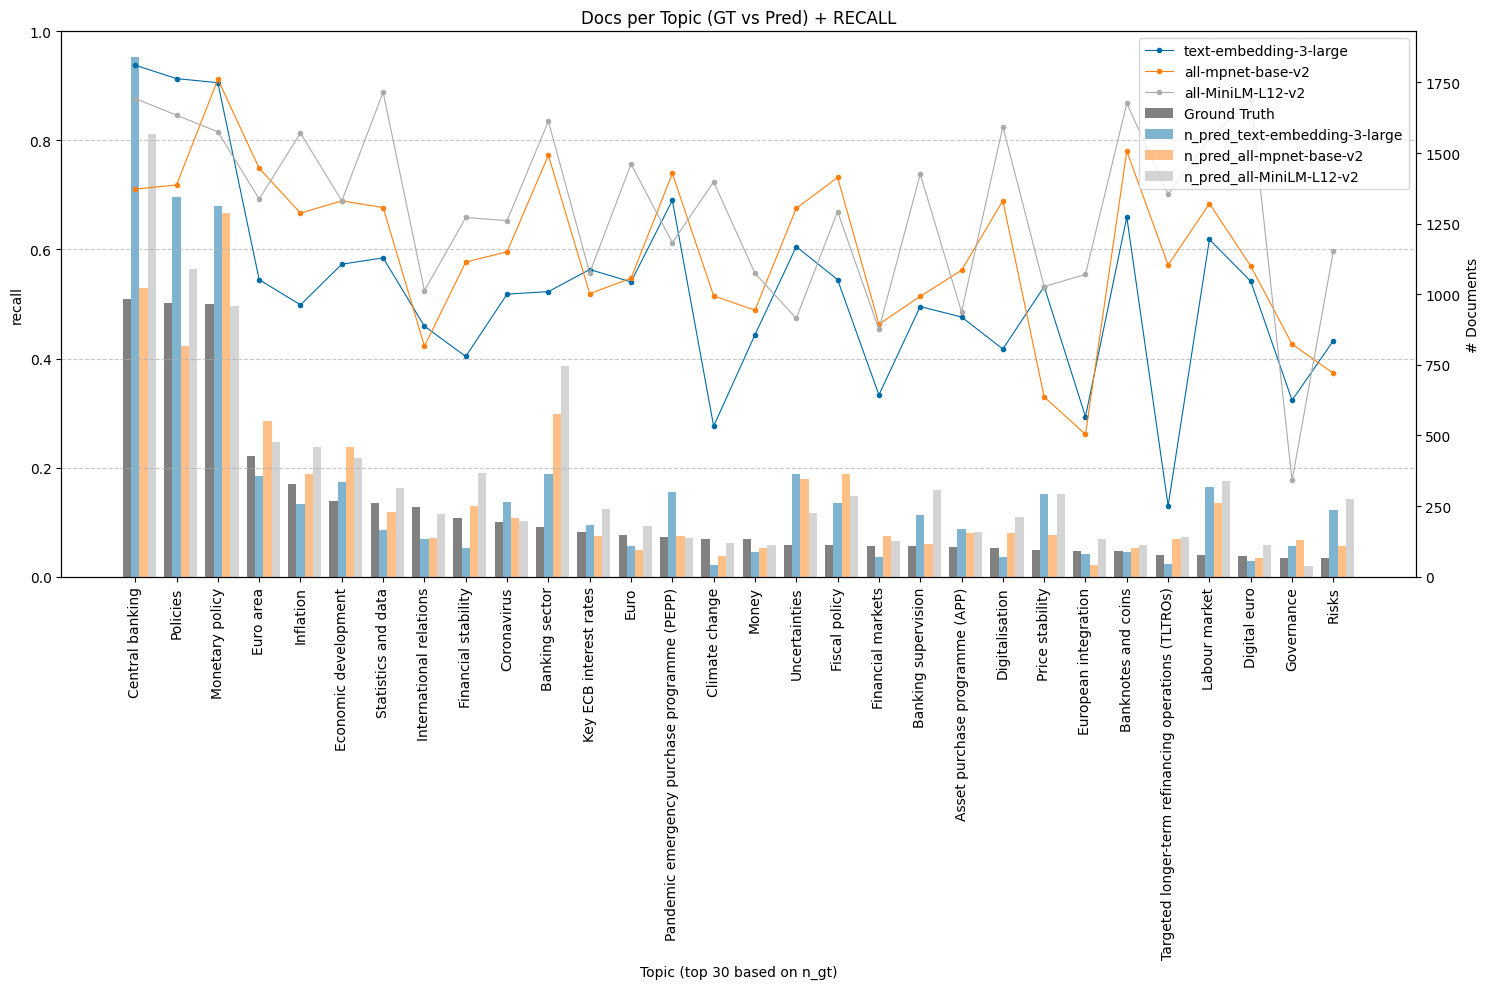

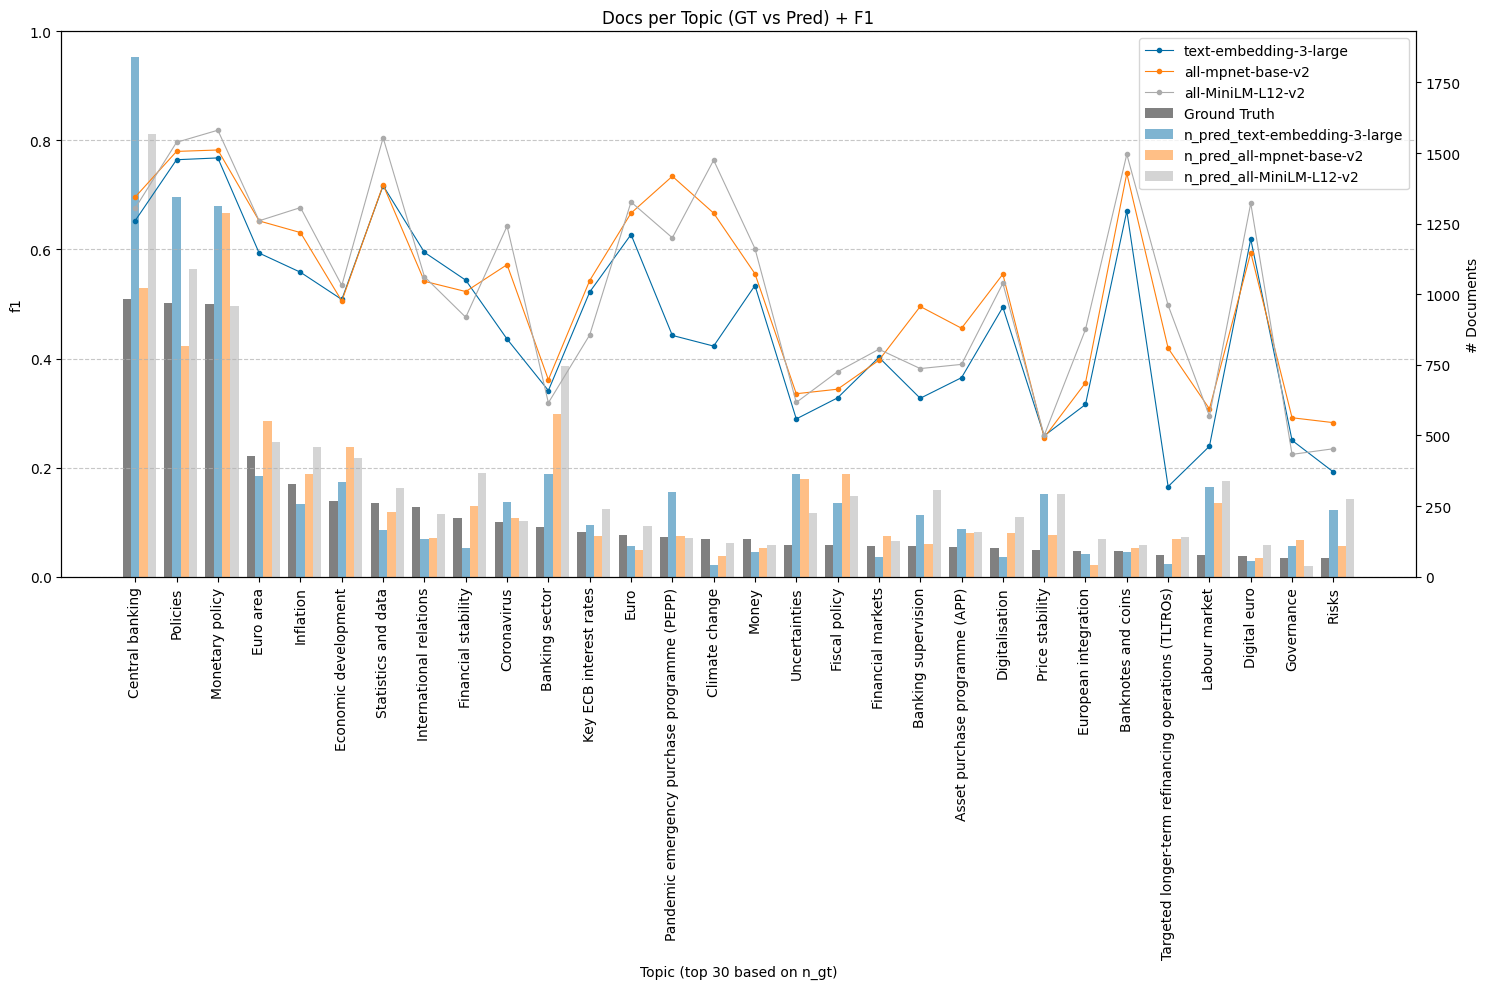

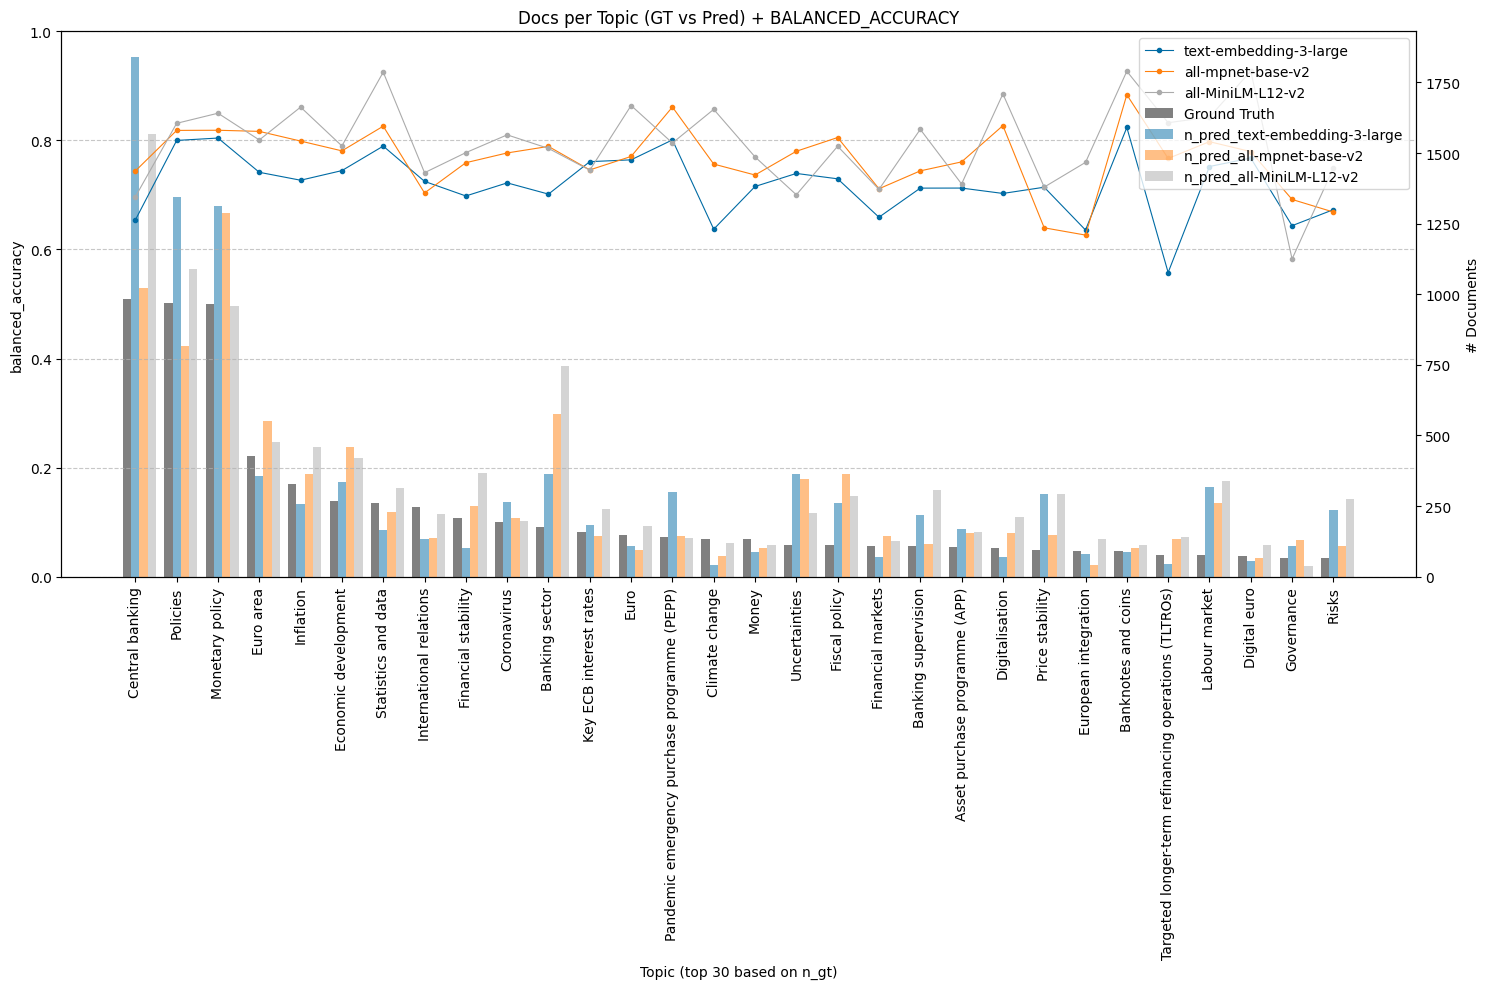

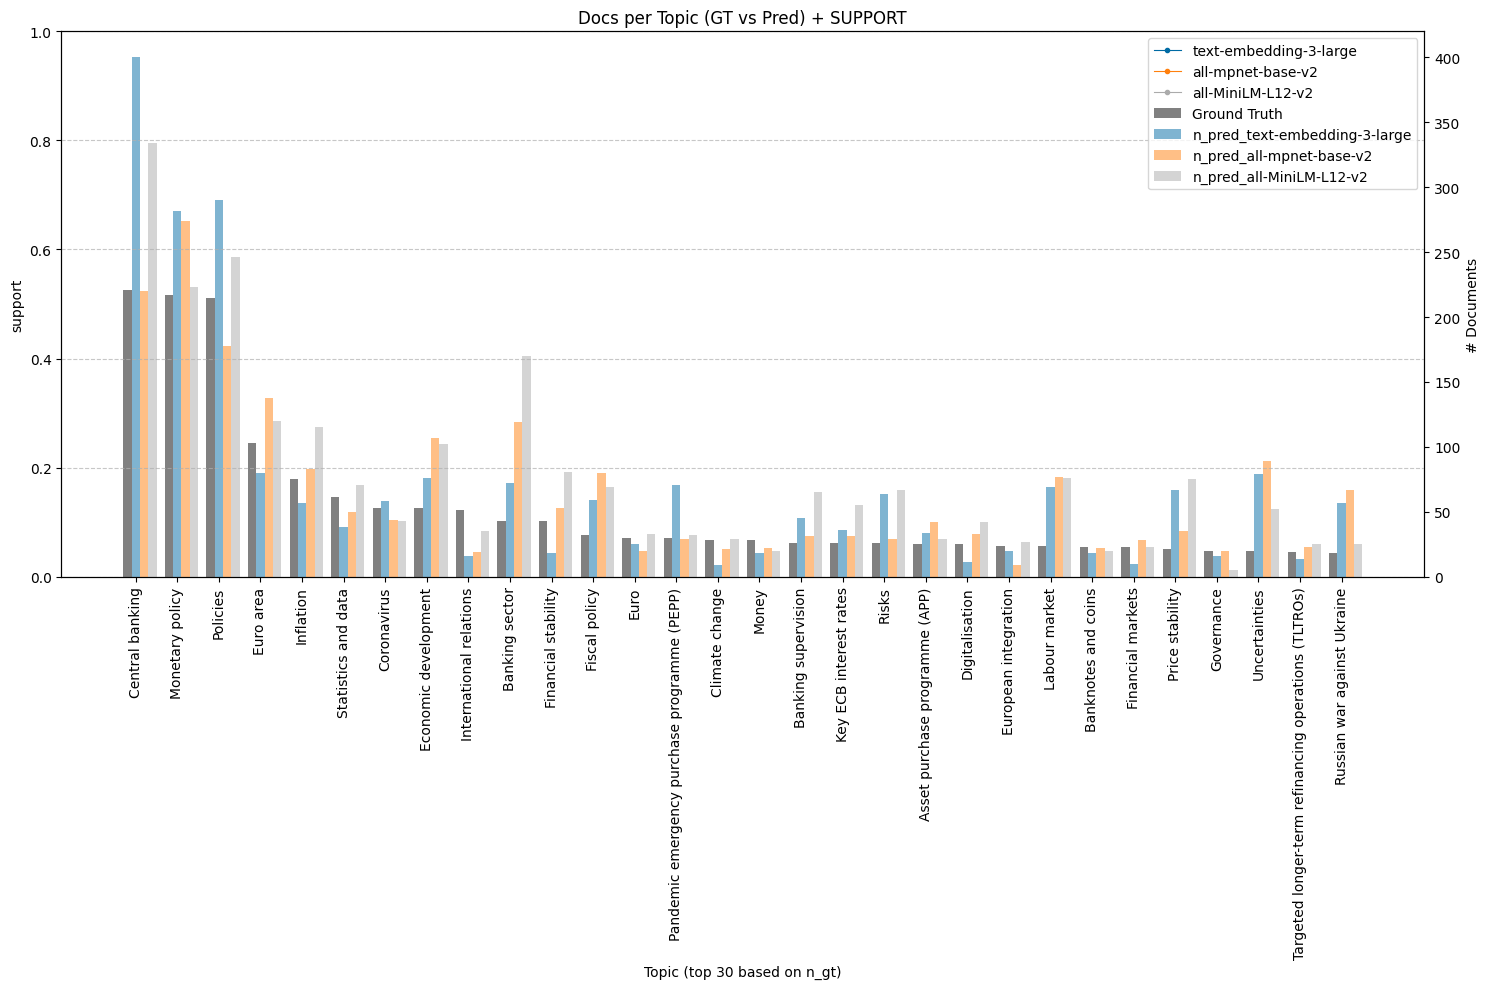

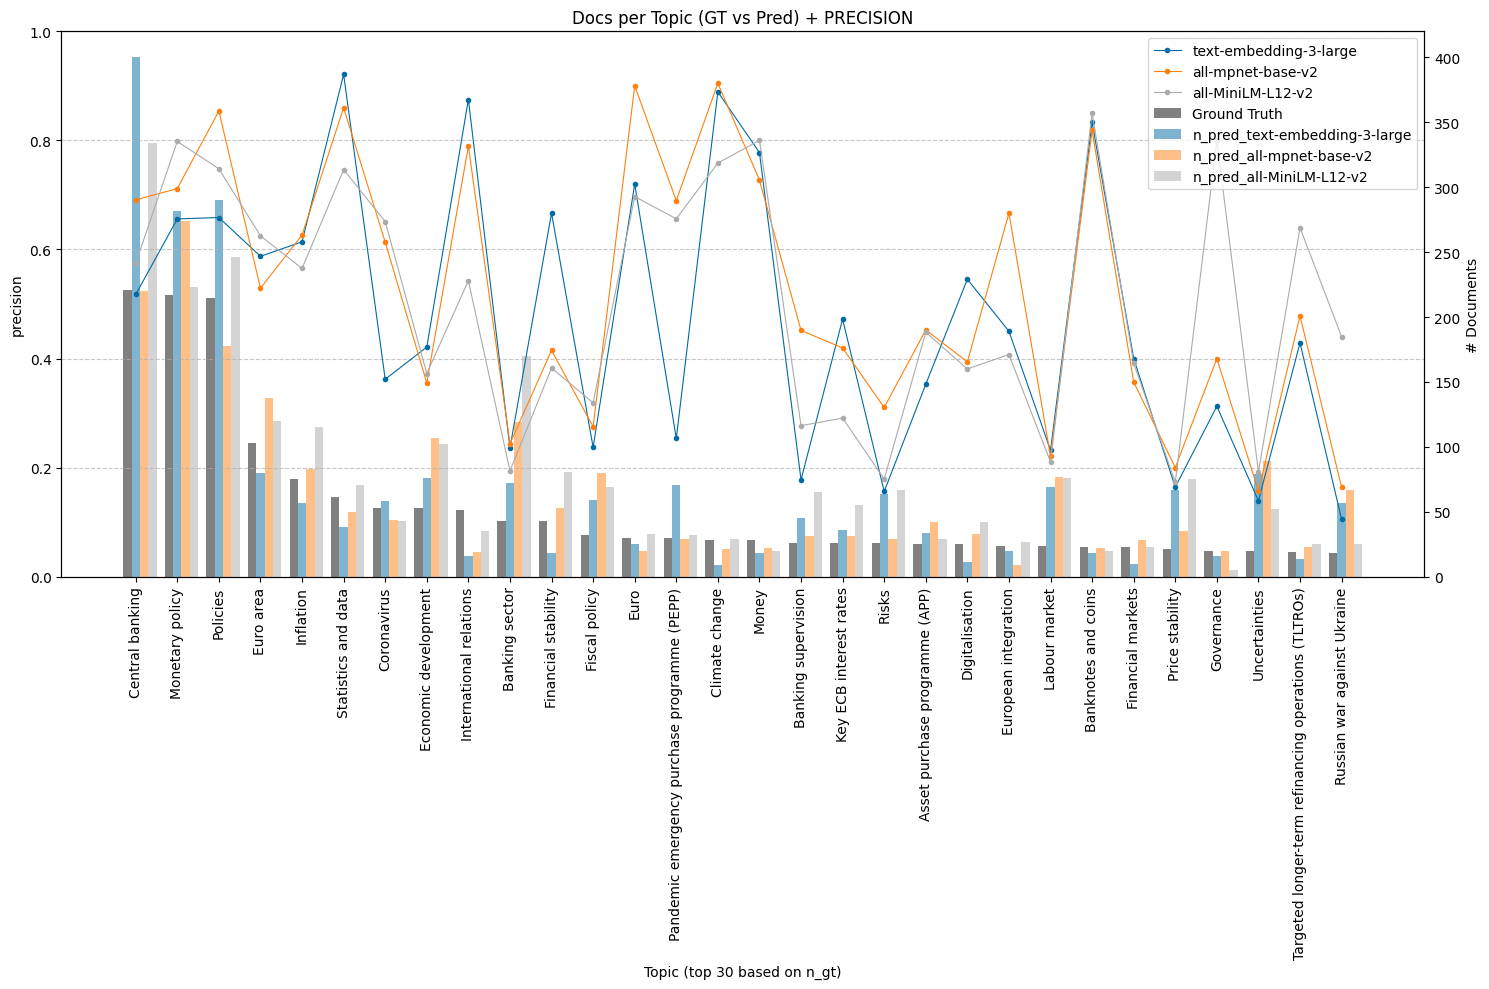

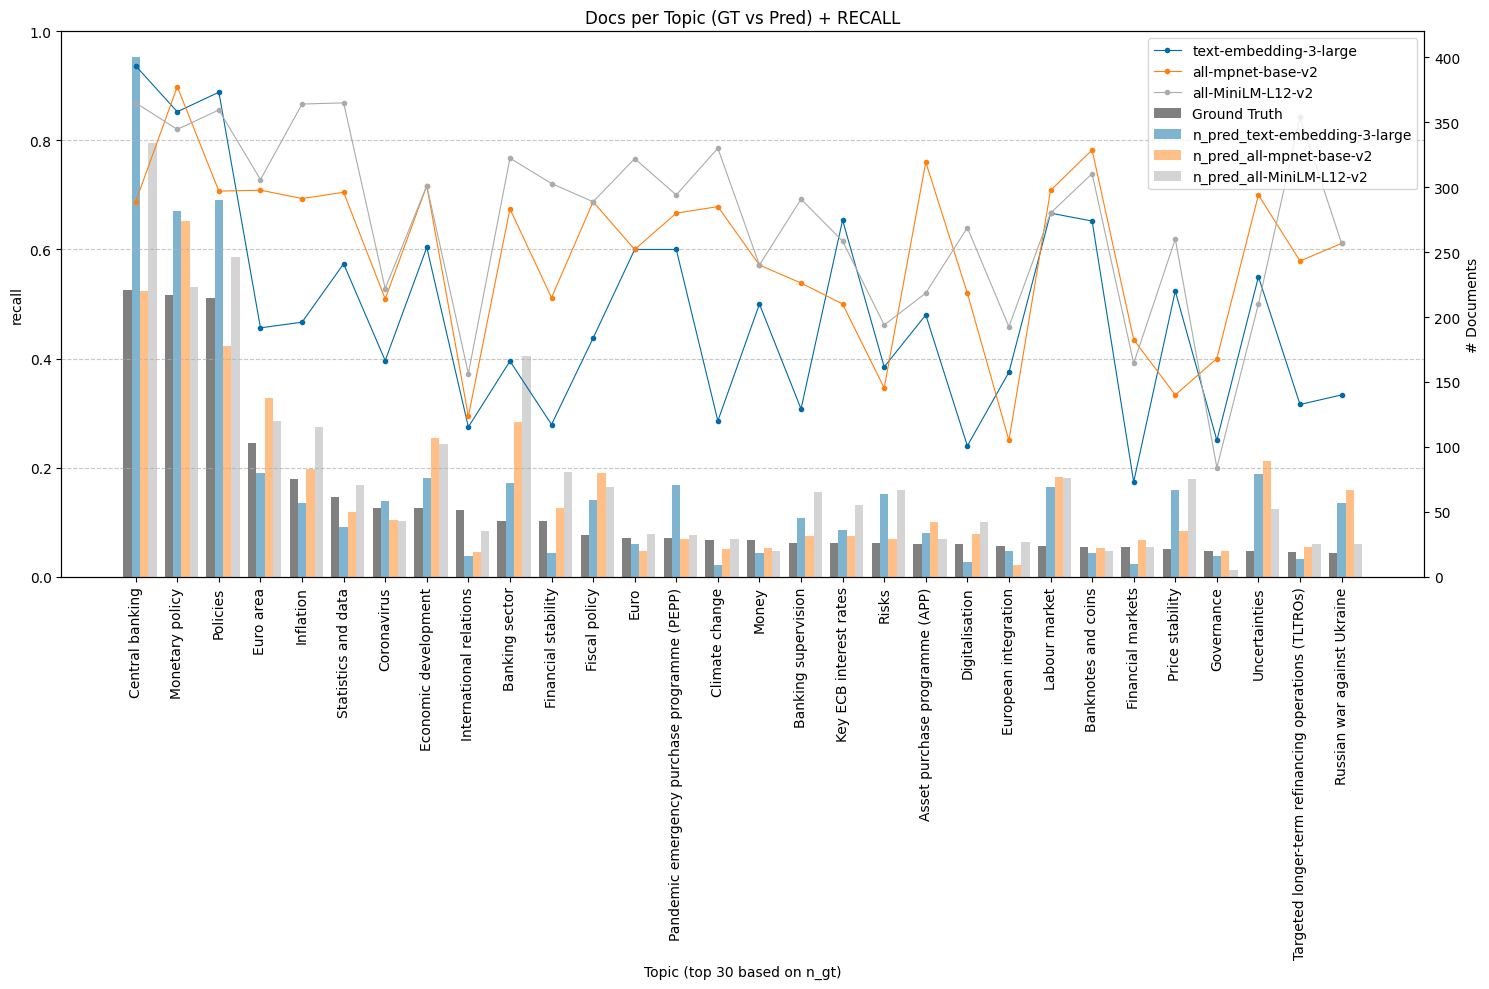

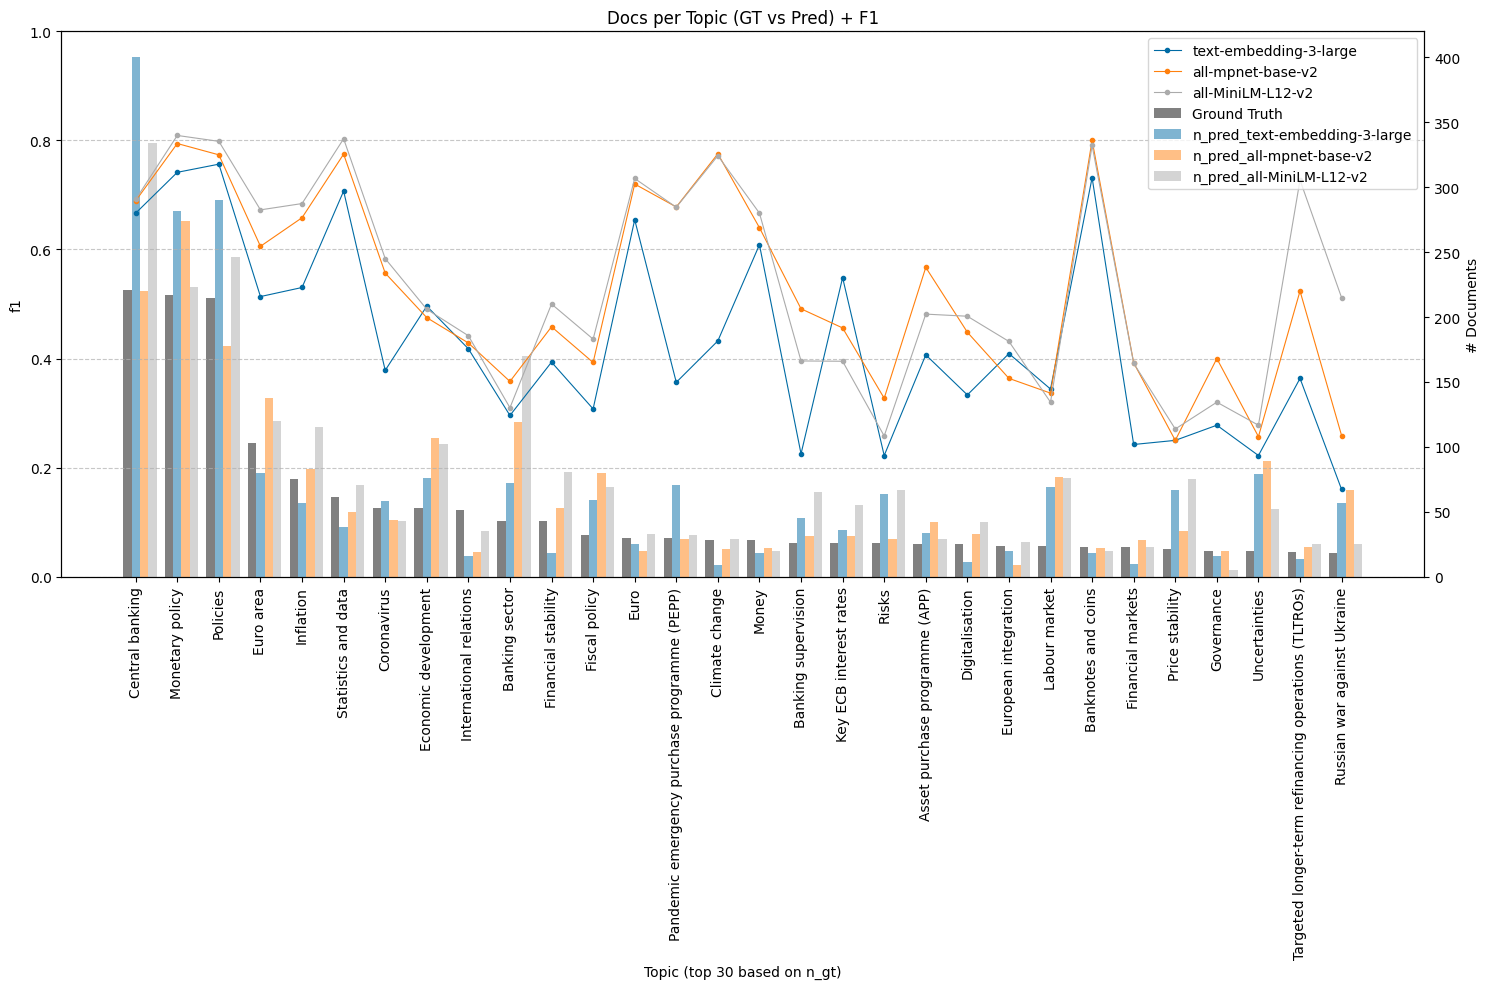

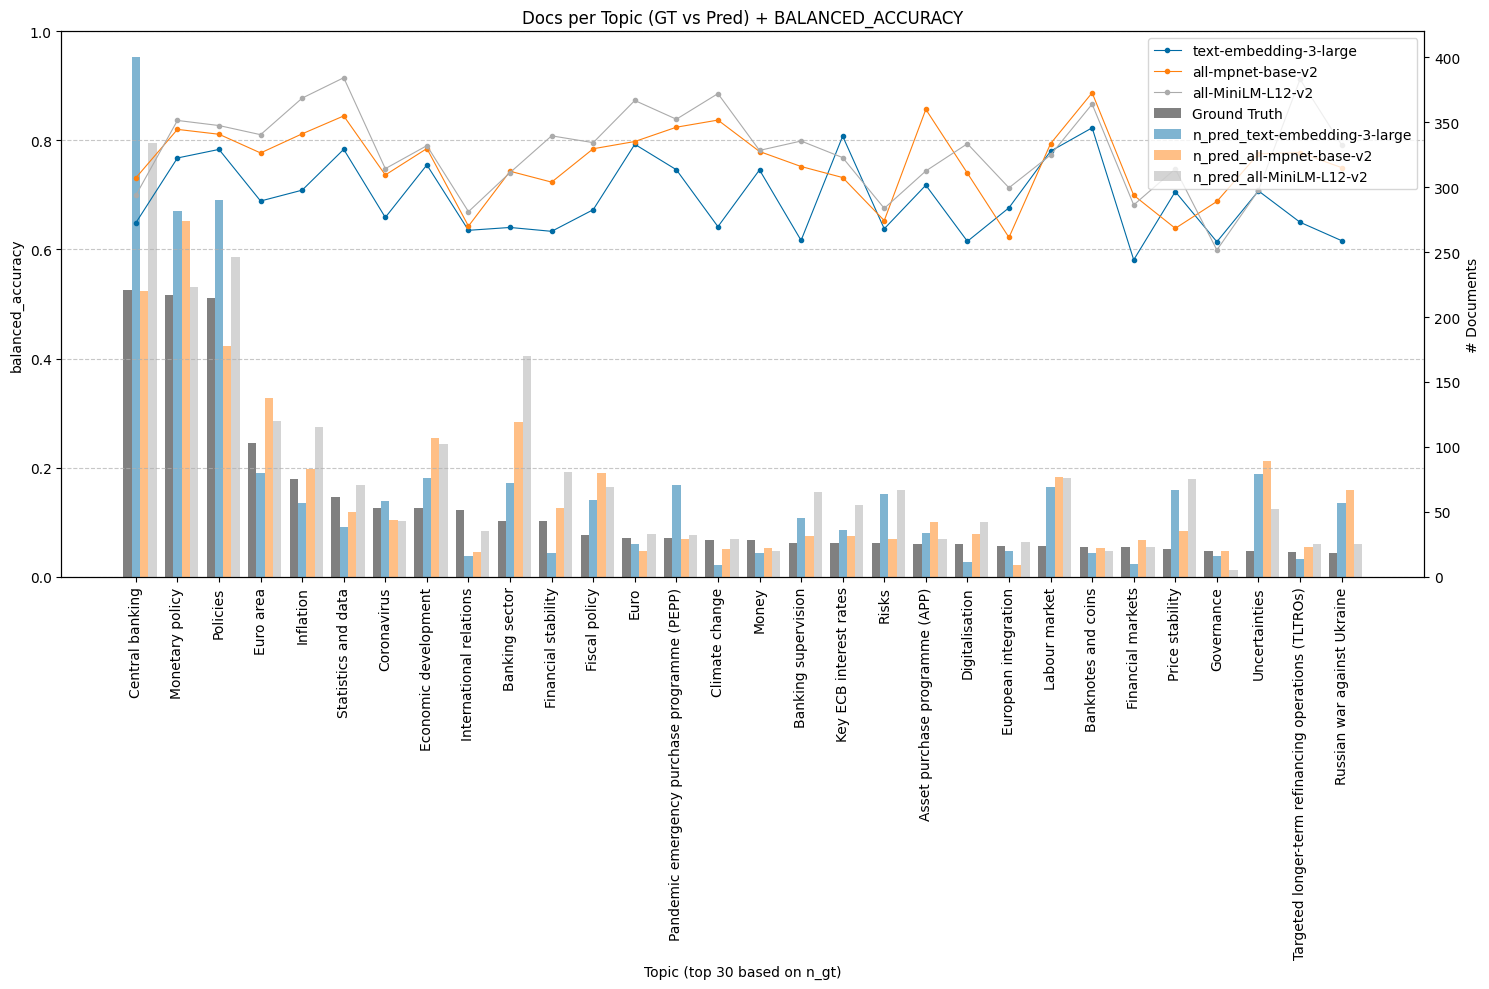

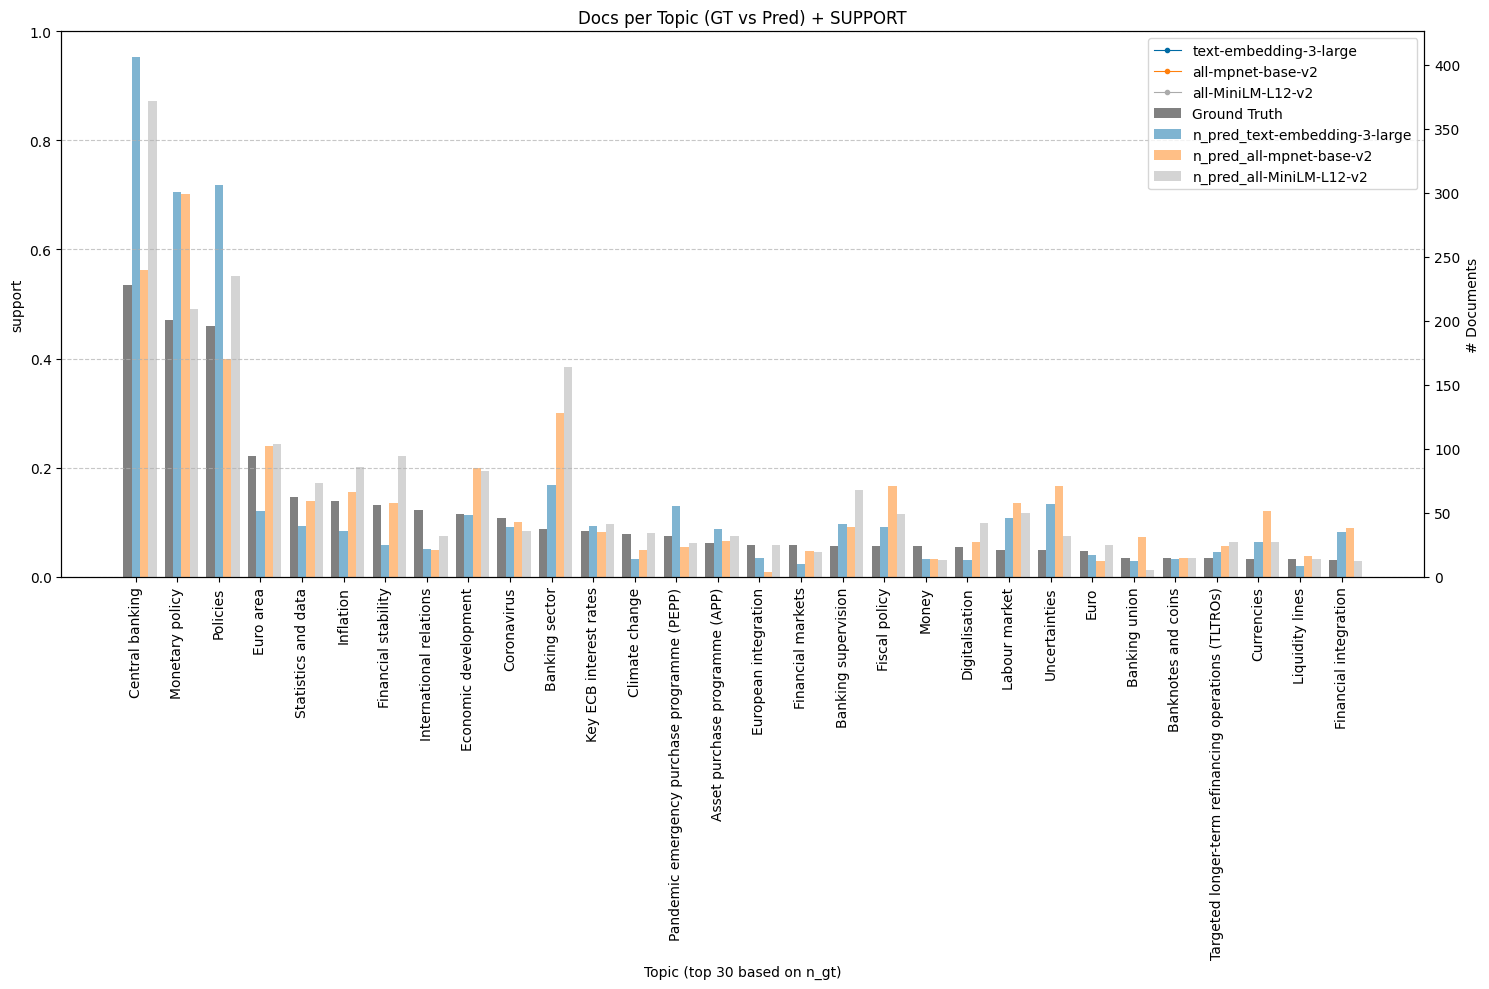

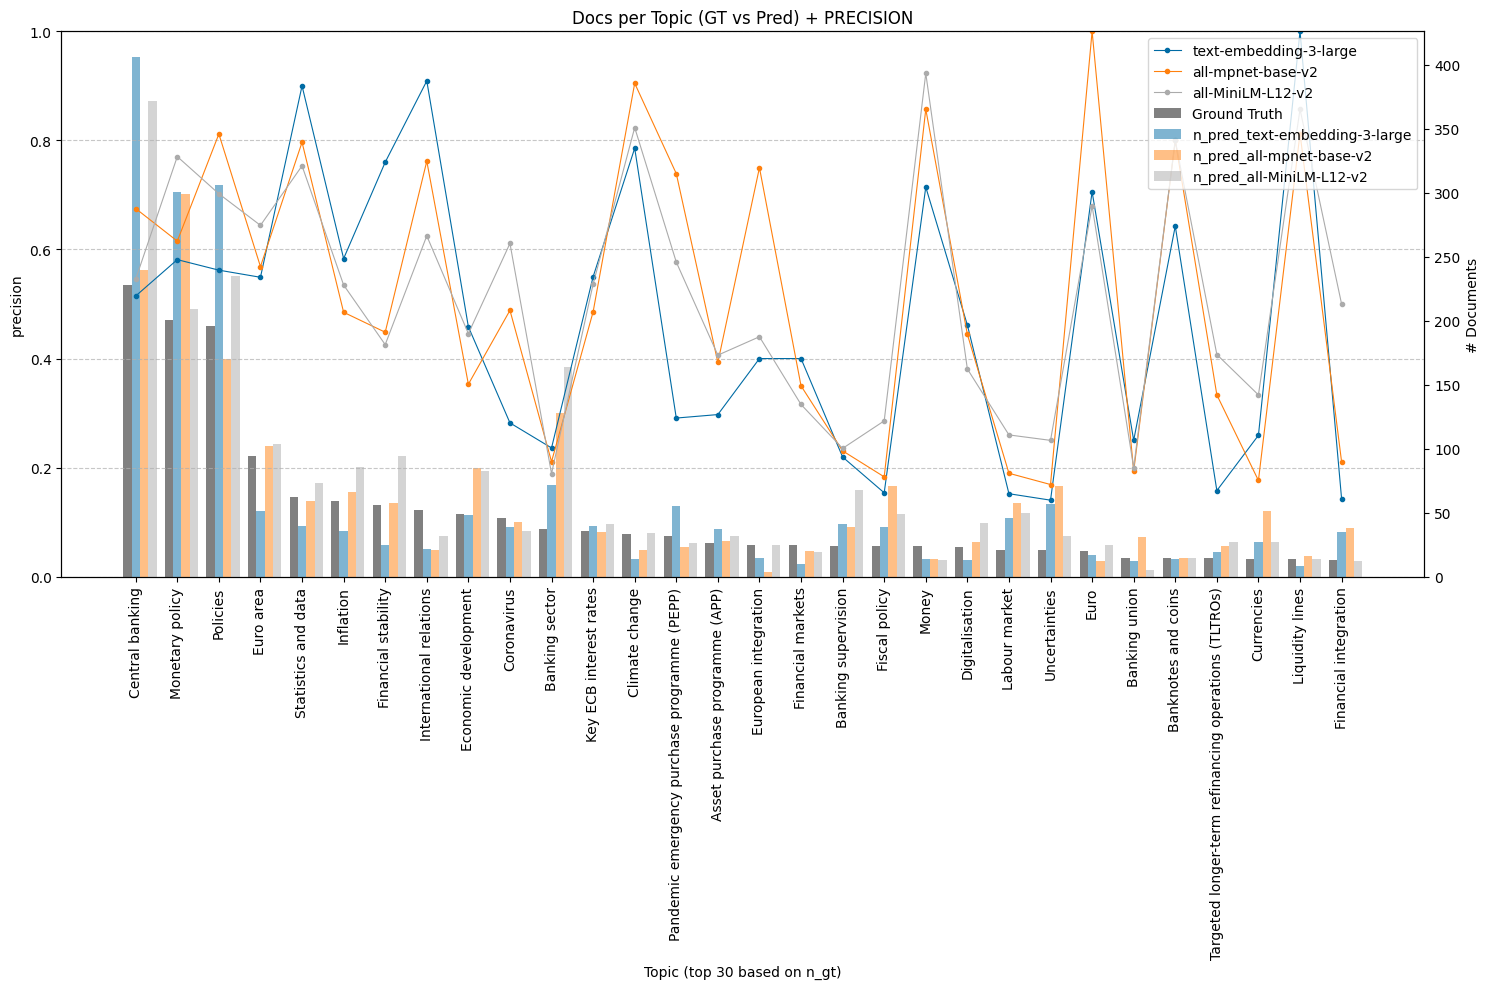

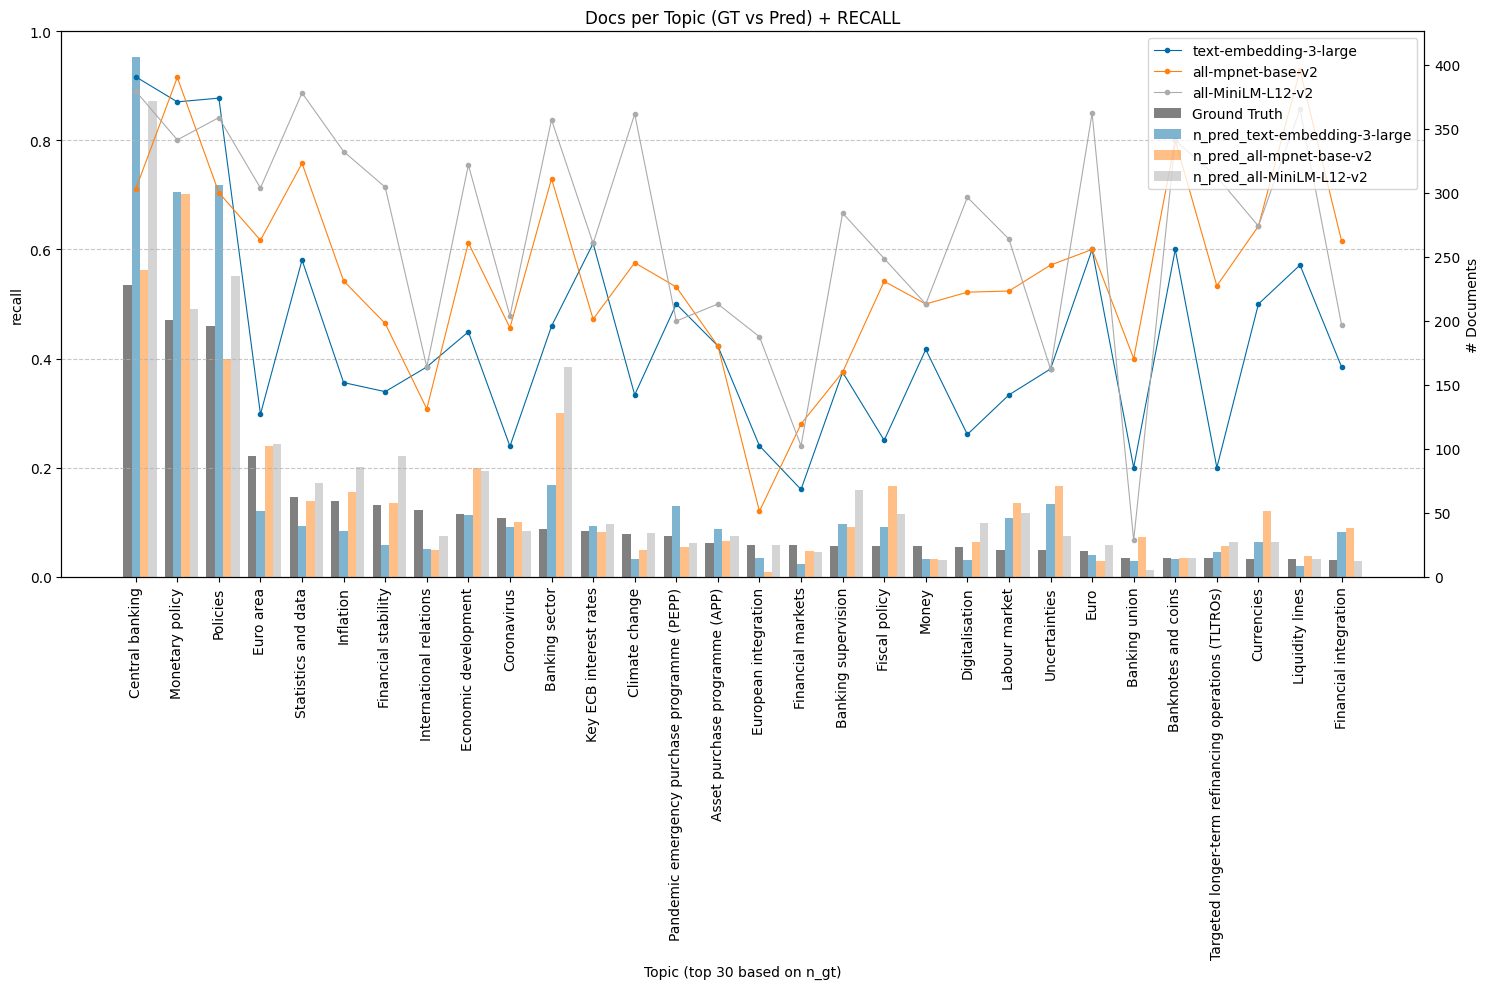

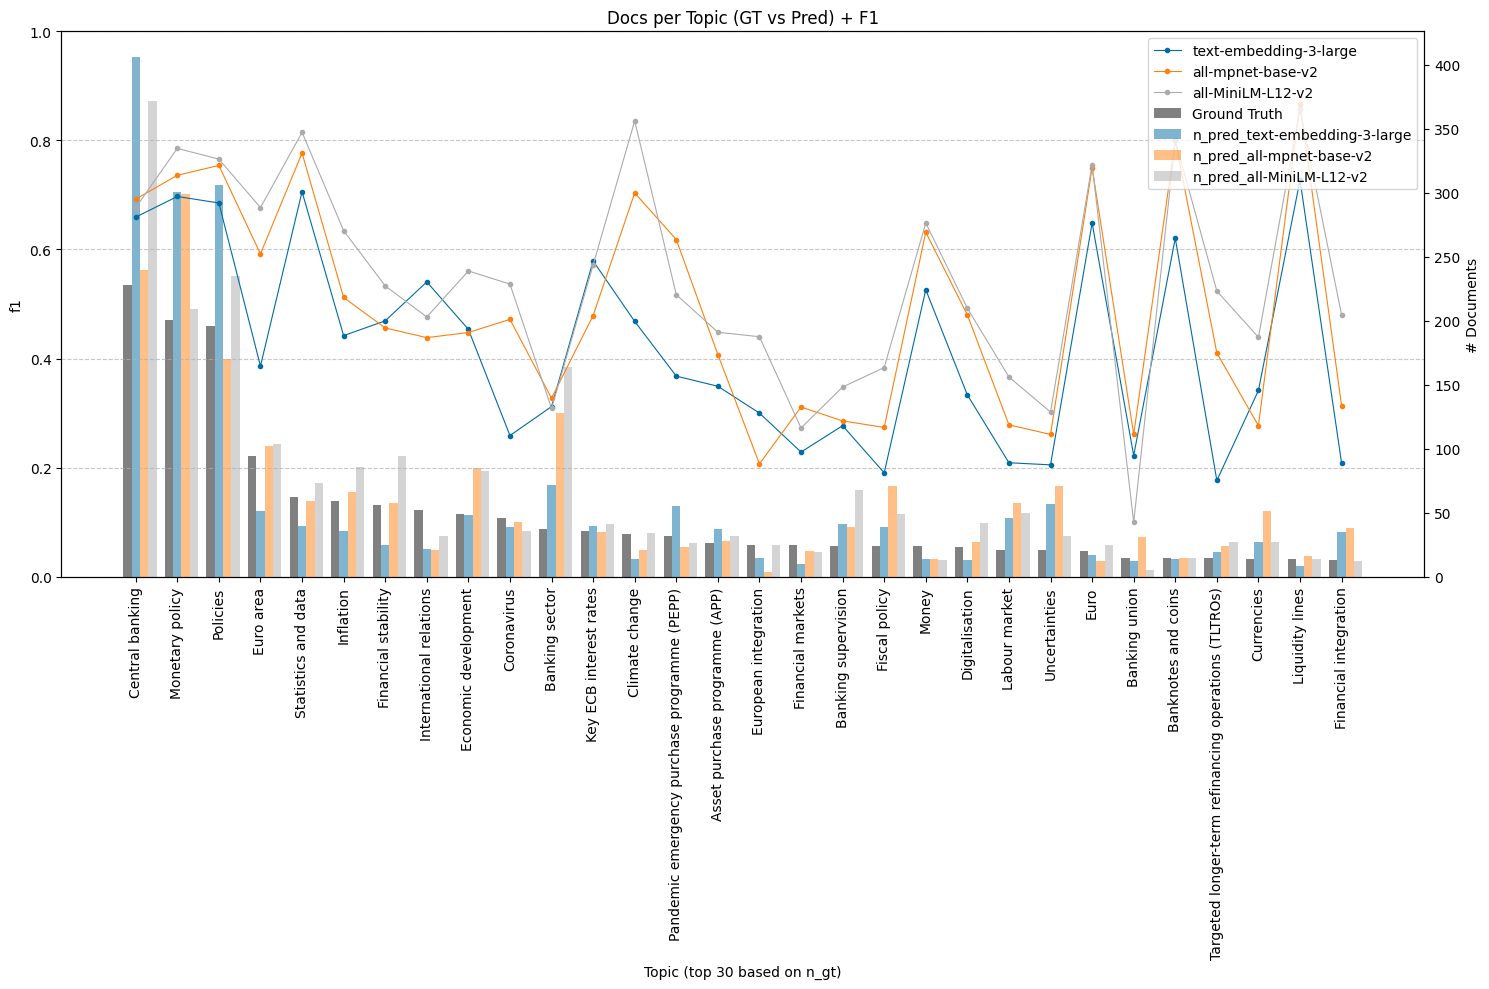

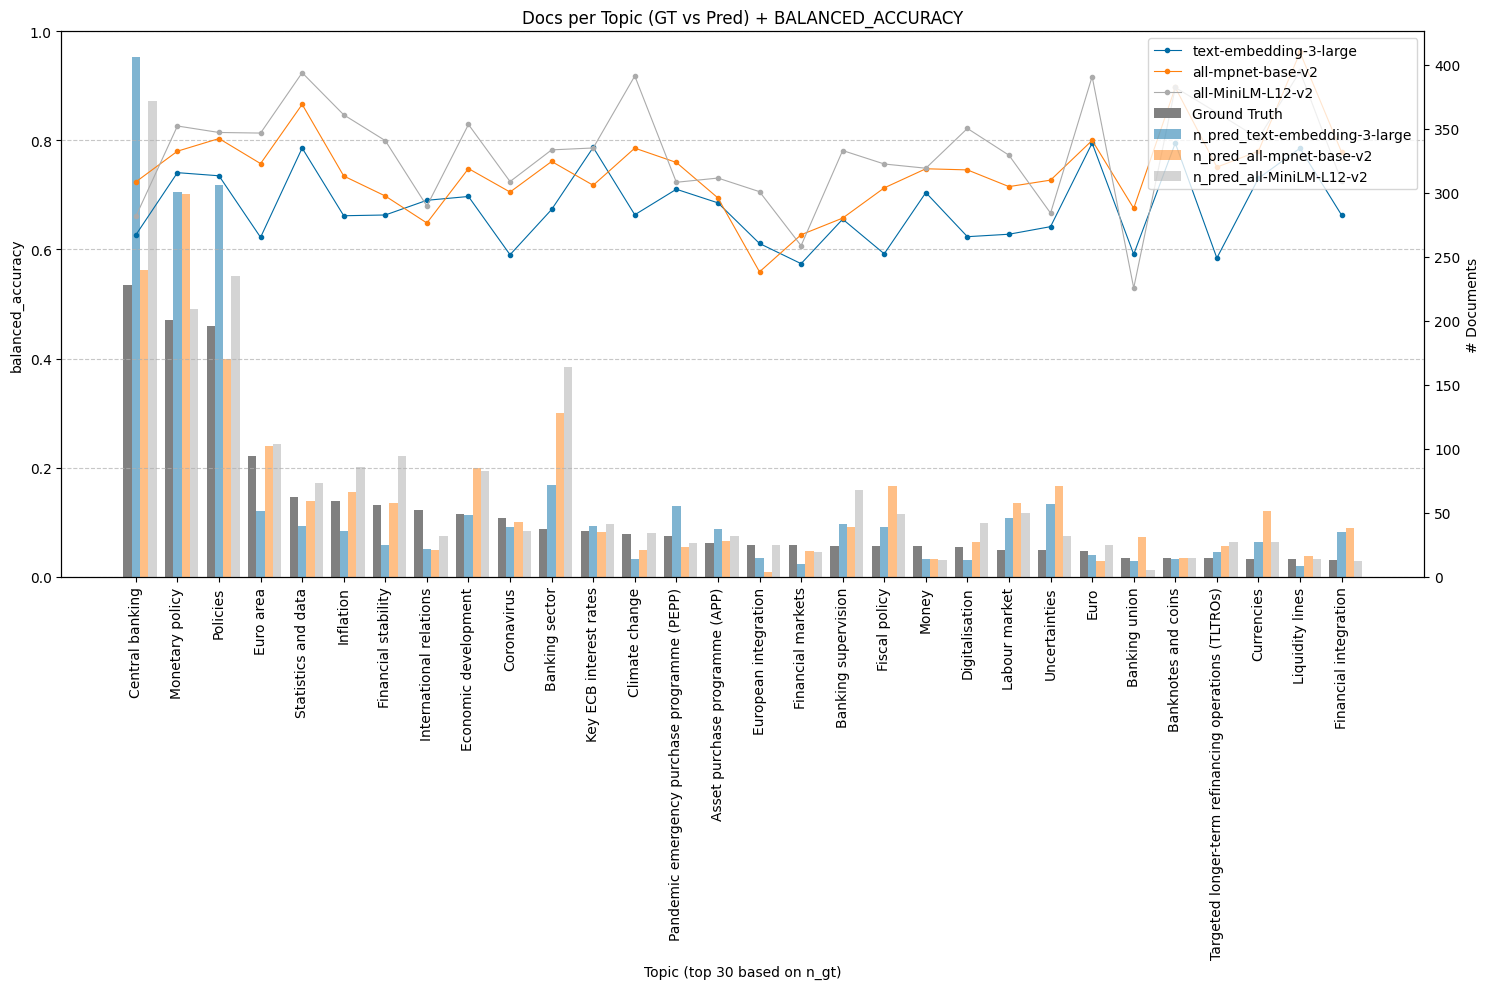

In [37]:
for part in ['train', 'val', 'test']:
    res_dfs = {name: models_ext[name][f"{part}_df"] for name in embedding_models}
    metr_dfs = {name: models_ext[name][f"{part}_per_label_table"] for name in embedding_models}
    for m in ['support', 'precision', 'recall', 'f1', 'balanced_accuracy']:
        plot_topic_metric_per_model(
            res_dfs, 
            metr_dfs, 
            metric = m, 
            top_k = 30, 
            pred_col = "pred_mapped", 
            gt_col = "topic_label",
            save = MODEL_DIR / f"{part}_per_topic_{m}_all_models.png")

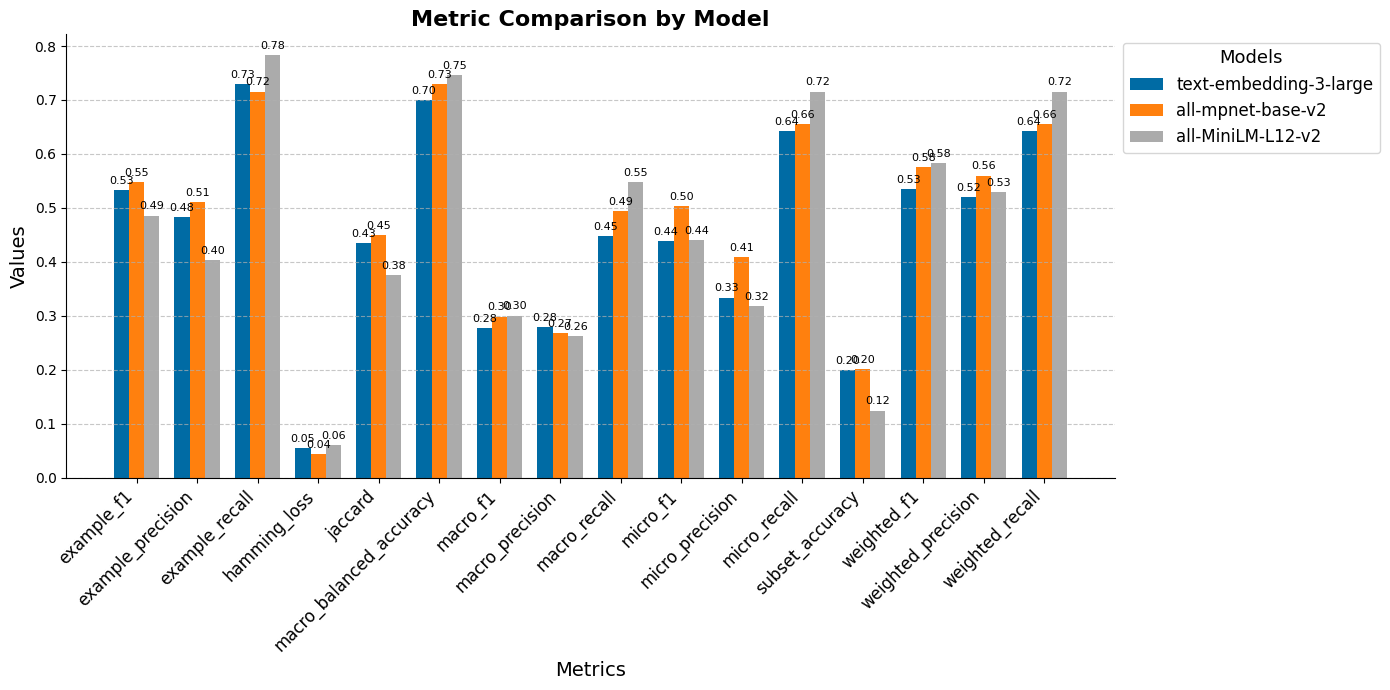

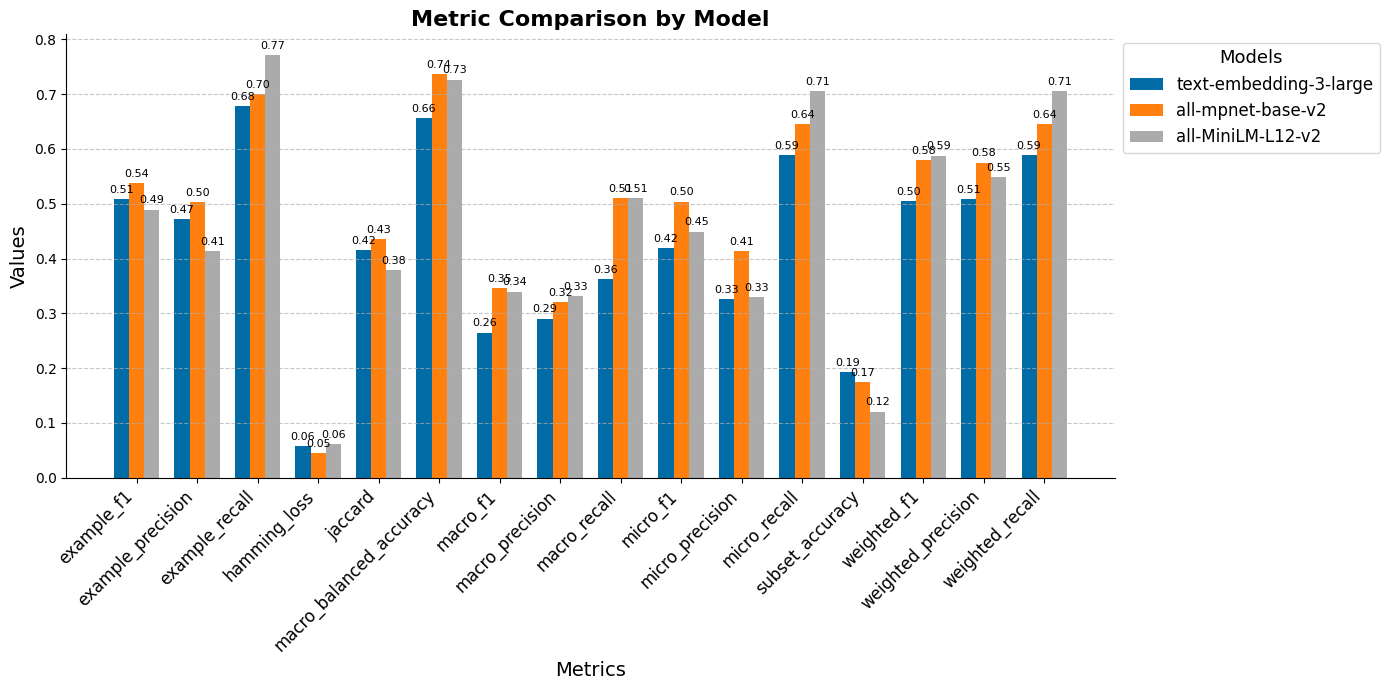

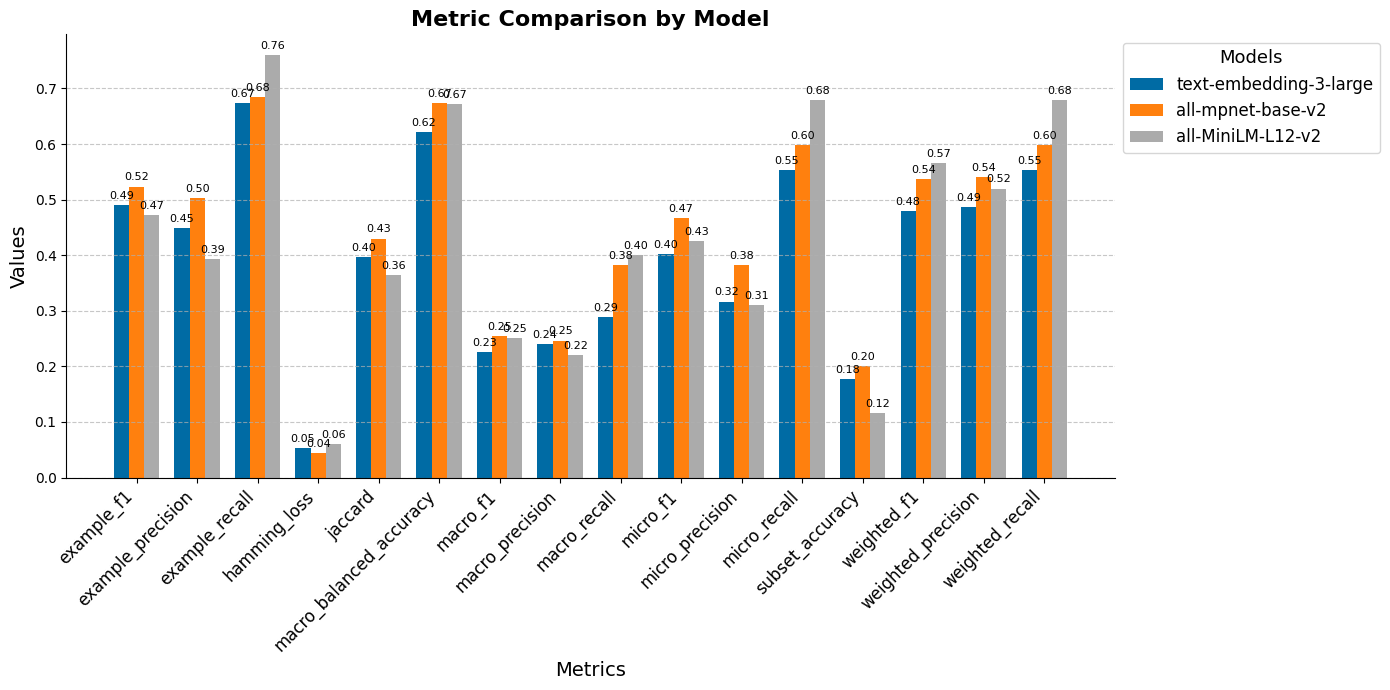

In [39]:
metrics_all = {}
metrics_all['metric'] = list(sorted(models_ext['text-embedding-3-large']['train_all_metrics'].keys()))
for part in ['train', 'val', 'test']:
    for name in embedding_models: 
        temp_dict = dict(sorted(models_ext[name][f'{part}_all_metrics'].items()))
        metrics_all[name] = list(temp_dict.values())
    metrics_all_df = pl.DataFrame(metrics_all)

    metrics_all_df.write_csv(MODEL_DIR / f'topic_model_all_metrics_per_model_{part}.csv')
    plot_metrics_per_model(metrics_all_df, save = MODEL_DIR / f'{part}_all_metrics_per_model.png')

In [53]:
vars(models_ext['text-embedding-3-large']['pipeline'])

{'embedding_model_name': 'text-embedding-3-large',
 'data_dir_path': WindowsPath('c:/Users/povhi/OneDrive/01_Uni/03_TU Wien/MSc Data Science/09_Interdisciplinary_Project/ECB_Topic_Chronicles/data'),
 'data': shape: (2_963, 21)
 ┌──────┬────────────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
 │ id   ┆ date       ┆ category   ┆ title      ┆ … ┆ category_b ┆ topic_lab ┆ chunks    ┆ chunks_em │
 │ ---  ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ase        ┆ el        ┆ ---       ┆ beddings  │
 │ u32  ┆ date       ┆ str        ┆ str        ┆   ┆ ---        ┆ ---       ┆ list[str] ┆ ---       │
 │      ┆            ┆            ┆            ┆   ┆ str        ┆ list[i64] ┆           ┆ list[list │
 │      ┆            ┆            ┆            ┆   ┆            ┆           ┆           ┆ [f64]]    │
 ╞══════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
 │ 0    ┆ 1997-04-25 ┆ Press      ┆ "EUR" -    ┆ … ┆ Press 

In [ ]:
import polars as pl

df = pl.read_parquet(r'data\blogs_articles\combined_parsed_ecb_articles.parquet')


[Date,
 String,
 String,
 String,
 String,
 List(String),
 UInt64,
 Boolean,
 String,
 UInt64,
 String,
 String,
 String,
 List(String),
 String,
 String,
 String]

In [7]:
df['category_base'].value_counts()['category_base'].to_list()

['Euro area financial vehicle corporation statistics',
 'Governing Council statement',
 'Euro money market',
 'Financial Stability Review',
 'Speech',
 'Environmental Statement',
 'Annual Report',
 'Financial integration and structure box',
 'Annual consolidated balance sheet of the Eurosystem',
 'TARGET Annual Report',
 'MFI interest rate statistics',
 'Monetary policy account',
 'Financial integration and structure in the euro area',
 'public consultation',
 'Euro area economic and financial developments by institutional sector (early)',
 'Interview',
 'Consumer Expectation Survey',
 'Balance of payments (quarterly)',
 'Euro area bank lending survey',
 'Balance of payments (monthly)',
 'Other publication',
 'Euro area securities issues statistics',
 'Euro area pension fund statistics',
 'Study on the payment attitudes of consumers in the euro area (SPACE)',
 'Podcast',
 'Euro area economic and financial developments by institutional sector (full)',
 'Euro area insurance corporations 

In [4]:
df.head(3)

shape: (3, 17)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ date       ┆ category   ┆ title     ┆ filter_ty ┆ … ┆ authors   ┆ suffix ┆ filename  ┆ category_ │
│ ---        ┆ ---        ┆ ---       ┆ pe        ┆   ┆ ---       ┆ ---    ┆ ---       ┆ base      │
│ date       ┆ str        ┆ str       ┆ ---       ┆   ┆ list[str] ┆ str    ┆ str       ┆ ---       │
│            ┆            ┆           ┆ str       ┆   ┆           ┆        ┆           ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ 1997-04-25 ┆ Press      ┆ "EUR" -   ┆ topic     ┆ … ┆ null      ┆ html   ┆ pr970425. ┆ Press     │
│            ┆ release    ┆ the new   ┆           ┆   ┆           ┆        ┆ en.html   ┆ release   │
│            ┆            ┆ currency  ┆           ┆   ┆           ┆        ┆           ┆           │
│            ┆            ┆ code …    ┆           ┆   ┆           ┆        ┆           ┆           │
│ 1997-07-01 ┆ Press      ┆ Change of ┆ topic     ┆ … ┆ null      ┆ html   ┆ pr970701. ┆ Press     │
│            ┆ release    ┆ presidenc ┆           ┆   ┆           ┆        ┆ en.html   ┆ release   │
│            ┆            ┆ y of the  ┆           ┆   ┆           ┆        ┆           ┆           │
│            ┆            ┆ Eu…       ┆           ┆   ┆           ┆        ┆           ┆           │
│ 1997-07-02 ┆ Press      ┆ Selection ┆ topic     ┆ … ┆ null      ┆ html   ┆ pr970702_ ┆ Press     │
│            ┆ release    ┆ and       ┆           ┆   ┆           ┆        ┆ 1.en.html ┆ release   │
│            ┆            ┆ further   ┆           ┆   ┆           ┆        ┆           ┆           │
│            ┆            ┆ developm… ┆           ┆   ┆           ┆        ┆           ┆           │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴────────┴───────────┴───────────┘

In [3]:
3494/9525

0.3668241469816273